In [4]:
%load_ext autoreload
%autoreload 2

In [329]:
from gpt3forchem.data import get_photoswitch_data
from gpt3forchem.input import generate_inverse_photoswitch_prompts
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_prediction, extract_inverse_prediction
import time
from sklearn.model_selection import train_test_split
from gpt3forchem.output import FrechetBenchmark, KLDivBenchmark, test_inverse_photoswitch
import seaborn as sns

import matplotlib.pyplot as plt

In [181]:
data = get_photoswitch_data()
data = data.dropna(subset=['E isomer pi-pi* wavelength in nm', 'E isomer n-pi* wavelength in nm'])

In [182]:
data

,index,SMILES,rate of thermal isomerisation from Z-E in s-1,Solvent used for thermal isomerisation rates,Z PhotoStationaryState,E PhotoStationaryState,E isomer pi-pi* wavelength in nm,Extinction,E isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1,Z isomer pi-pi* wavelength in nm,Extinction.1,Z isomer n-pi* wavelength in nm,Extinction coefficient in M-1 cm-1.1,Wiberg index,E-Z irradiation wavelength in nm,Z-E irradiation wavelength,Irradiation solvent,PBE0 DFT E isomer pi-pi* wavelength in nm,PBE0 DFT E isomer n-pi* wavelength in nm,PBE0 DFT Z isomer pi-pi* wavelength in nm,PBE0 DFT Z isomer n-pi* wavelength in nm,TPSSh/6-31G** DFT E isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT E isomer n-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer pi-pi* wavelength in nm,TPSSh/6-31G** DFT Z isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT E isomer n-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer pi-pi* wavelength in nm,CAM-B3LYP/6-31G** DFT Z isomer n-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm,BHLYP/6-31G* Z isomer pi-pi* wavelength in nm,BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm,name,selfies,wavelength_cat,inchi
0,0,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,2.100000e-07,MeCN,76.0,72.0,310.0,1.67,442.0,0.0373,290.0,0.243,428.0,0.1010,1.896,355,532,MeCN,305.0,480.0,286.0,448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][N][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C10H10N4/c1-14-8-7-10(13-14)12-11-9-5...
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,3.800000e-07,MeCN,90.0,84.0,310.0,1.87,438.0,0.0505,272.0,0.489,434.0,0.1270,1.899,355,532,MeCN,306.0,473.0,284.0,448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=N][C][=Branch1][Ring2][=N][Ring1]...,very small,InChI=1S/C9H9N5/c1-14-7-10-9(13-14)12-11-8-5-3...
2,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,1.500000e-06,MeCN,96.0,87.0,325.0,1.74,428.0,0.0612,286.0,0.515,438.0,0.1360,1.874,355,532,MeCN,317.0,458.0,302.0,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][C][C][C][=Branch1][Ri...,very small,InChI=1S/C11H12N4/c1-9-8-15(2)14-11(9)13-12-10...
3,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,7.600000e-09,MeCN,98.0,70.0,328.0,1.66,417.0,0.0640,275.0,0.806,403.0,0.0666,1.849,355,532,MeCN,318.0,447.0,278.0,409.0,328.0,455.0,295.0,410.0,305.0,427.0,256.0,401.0,NaN,NaN,NaN,NaN,NaN,[C][NH0][C][=C][Branch1][Branch1][C][=N][Ring1...,very small,InChI=1S/C10H10N4/c1-14-8-10(7-11-14)13-12-9-5...
4,5,C[N]1N=C(C)C(=C1C)N=NC2=CC=CC=C2,7.700000e-07,MeCN,98.0,98.0,335.0,2.27,425.0,0.0963,296.0,0.577,441.0,0.2300,1.837,355,532,MeCN,327.0,443.0,297.0,460.0,337.0,453.0,311.0,462.0,314.0,422.0,279.0,449.0,NaN,NaN,NaN,NaN,"phenyl-(1,3,5-trimethylpyrazol-4-yl)diazene",[C][NH0][N][=C][Branch1][C][C][C][=Branch1][Br...,very small,InChI=1S/C12H14N4/c1-9-12(10(2)16(3)15-9)14-13...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,162,CC1=CC(/N=N/C2=CC(C)=C(C)C=C2)=CC=C1C,NaN,NaN,NaN,NaN,333.0,NaN,441.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,356.0,473.0,NaN,NaN,NaN,NaN,NaN,NaN,343.0,445.0,NaN,NaN,NaN,NaN,NaN,NaN,"BIS(3,4-DIMETHYLPHENYL)DIAZENE",[C][C][=C][C][Branch1][P][/N][=N][/C][=C][C][B...,very small,InChI=1S/C16H18N2/c1-11-5-7-15(9-13(11)3)17-18...
149,163,CC1=C(Cl)C=CC=C1/N=N/C2=C(C)C(Cl)=CC=C2,NaN,NaN,NaN,NaN,329.0,NaN,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,341.0,495.0,NaN,NaN,NaN,NaN,NaN,NaN,325.0,471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[C][C][=C][Branch1][C][Cl][C][=C][C][=C][Ring1...,very small,InChI=1S/C14H12Cl2N2/c1-9-11(15)5-3-7-13(9)17-...
150,164,CC1=CC(Cl)=CC=C1/N=N/C2=C(C)C=C(Cl)C=C2,NaN,NaN,NaN,NaN,346.0,NaN,461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CH,379.0,506.0,NaN,NaN,NaN,NaN,NaN,NaN,360.0,481.0,NaN,NaN,NaN,NaN,NaN,NaN,Bis(4-chloro-2-methylphenyl)diazene,[C][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring

In [184]:
train_df, test_df = train_test_split(data, train_size=100, random_state=None, stratify=data["wavelength_cat"])

In [237]:
train_prompts_smiles = generate_inverse_photoswitch_prompts(train_df, 'SMILES')
test_prompts_smiles = generate_inverse_photoswitch_prompts(test_df, 'SMILES')

train_prompts_selfies = generate_inverse_photoswitch_prompts(train_df, 'selfies')
test_prompts_seflies = generate_inverse_photoswitch_prompts(test_df, 'selfies')

In [249]:
train_smiles = train_prompts_smiles['completion'].apply(lambda x: x.split('@@@')[0])
test_smiles = test_prompts_smiles['completion'].apply(lambda x: x.split('@@@')[0])
train_prompts_smiles['SMILES'] = train_smiles
test_prompts_smiles['SMILES'] = test_smiles


train_prompts_selfies['SMILES'] = train_smiles
test_prompts_seflies['SMILES'] = test_smiles

In [239]:
def train_inverse_model(df_train, representation):
    train_prompts = generate_inverse_photoswitch_prompts(
        df_train,
        representation=representation,
    )

    train_size = len(train_prompts)

    filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
    train_filename = f"run_files/{filename_base}_train_prompts_photoswitch_inverse_{representation}_{train_size}.jsonl"

    train_prompts.to_json(train_filename, orient="records", lines=True)

    modelname = fine_tune(train_filename, train_filename, "ada")
    return modelname, train_filename

In [246]:
def test_inverse_model(modelname, test_prompts, df_train, max_tokens: int =100, temperatures=None, representation="SMILES"): 
    temperatures = temperatures or  [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

    train_repr = df_train['completion'].apply(lambda x: x.split('@@@')[0])
    train_smiles = df_train['SMILES'].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature} for {representation}")
            result = test_inverse_photoswitch(
                test_prompts, modelname, train_smiles=train_smiles, temperature=temperature, max_tokens=max_tokens, representation=representation
            )

            results.append(result)
        except Exception as e:
            print(e)
            pass
    
    return results

In [241]:
model_smiles, train_filename_smiles = train_inverse_model(train_df, 'SMILES')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [242]:
results_smiles = test_inverse_model(model_smiles, test_prompts_smiles, train_prompts_smiles, representation='SMILES')

Testing temperature 0


2022-11-24 10:58:15.704 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.25


2022-11-24 10:59:29.341 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.5


2022-11-24 11:00:13.270 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.75


2022-11-24 11:01:01.891 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.0


2022-11-24 11:01:46.677 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.25


2022-11-24 11:02:19.783 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.5


2022-11-24 11:02:45.753 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


In [243]:
model_selfies, train_filename = train_inverse_model(train_df, 'selfies')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [250]:
results_selfies = test_inverse_model(model_selfies, test_prompts_seflies, train_prompts_selfies, representation='selfies')

Testing temperature 0 for selfies


2022-11-24 11:34:15.953 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=NOC(C)=C1/N=N/C2=CC=C(C)C=C2
2022-11-24 11:34:16.038 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.25 for selfies


2022-11-24 11:35:03.531 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: C1C=C1/N=N/C2=CC=CC=C2C=NC=C
2022-11-24 11:35:03.578 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.5 for selfies


2022-11-24 11:35:38.989 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(C(C)=NN1)/N=N/C2=CC(F)=CC=C2
2022-11-24 11:35:39.017 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.75 for selfies


2022-11-24 11:36:13.800 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: NC1=CC=CC=C1/N=N/C2=C(F)C=CC=C2F
2022-11-24 11:36:13.837 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.0 for selfies


2022-11-24 11:36:51.043 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=NOC(C)=C1/N=N/C2=CC(O)=CC=C2
2022-11-24 11:36:51.090 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.25 for selfies


2022-11-24 11:37:37.680 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=NOC(C)=C1/N=N/C2=CC(O)=CC=C2
2022-11-24 11:37:37.738 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.5 for selfies


2022-11-24 11:38:11.288 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: [N][C][=N][Branch1][=Bscl1][=becnes2][Branch2][C][Branch1][Ring1][Ob
2022-11-24 11:38:11.366 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [251]:
summarized_metrics_smiles = []

for metric in results_smiles:
    res = {
        'temperature': metric['meta']['temperature'],
         'fractions_valid_smiles': metric['fractions_valid_smiles'],
        'fractions_smiles_in_train': metric['fractions_smiles_in_train'],
        'unique_smiles': metric['unique_smiles'],
        'frechet_chemnet': metric['frechet_chemnet'][0],
        'pi_pi_star_mae': metric['pi_pi_star_metrics']['mean_absolute_error'],
        'n_pi_star_mae': metric['n_pi_star_metrics']['mean_absolute_error'],
    }
    summarized_metrics_smiles.append(res)

In [252]:
summarized_metrics_selfies = []

for metric in results_selfies:
    try:
        res = {
            'temperature': metric['meta']['temperature'],
            'fractions_valid_smiles': metric['fractions_valid_smiles'],
            'fractions_smiles_in_train': metric['fractions_smiles_in_train'],
            'unique_smiles': metric['unique_smiles'],
            'frechet_chemnet': metric['frechet_chemnet'][0],
            'pi_pi_star_mae': metric['pi_pi_star_metrics']['mean_absolute_error'],
            'n_pi_star_mae': metric['n_pi_star_metrics']['mean_absolute_error'],
        }
        summarized_metrics_selfies.append(res)
    except Exception as e:
        print(e)
        pass

In [253]:
import pandas as pd 

In [254]:
summarized_metrics_smiles = pd.DataFrame(summarized_metrics_smiles)

In [255]:
summarized_metrics_selfies = pd.DataFrame(summarized_metrics_selfies)

In [256]:
summarized_metrics_smiles

,temperature,fractions_valid_smiles,fractions_smiles_in_train,unique_smiles,frechet_chemnet,pi_pi_star_mae,n_pi_star_mae
0,0.00,1.000000,1.000000,0.074074,31.261643,10.352202,16.542582
1,0.25,1.000000,0.962963,0.481481,18.129407,12.320807,18.862905
2,0.50,0.925926,0.800000,0.680000,14.028975,16.815757,15.888342
3,0.75,0.962963,0.730769,0.846154,10.150410,16.923918,16.590871
4,1.00,0.814815,0.636364,0.954545,12.519774,18.900595,16.705321
5,1.25,0.407407,0.363636,0.909091,17.723569,35.793044,17.990552
6,1.50,0.111111,0.000000,1.000000,29.938051,18.967667,17.870842


In [257]:
summarized_metrics_selfies

,temperature,fractions_valid_smiles,fractions_smiles_in_train,unique_smiles,frechet_chemnet,pi_pi_star_mae,n_pi_star_mae
0,0.00,1.000000,1.000000,0.074074,22.287693,12.154209,18.700768
1,0.25,1.000000,0.962963,0.222222,17.381980,14.272996,17.960968
2,0.50,1.000000,0.777778,0.592593,14.146846,16.100918,17.083743
3,0.75,0.925926,0.760000,0.720000,13.776429,20.943504,15.033801
4,1.00,0.888889,0.416667,0.916667,19.937163,25.995480,17.335520
5,1.25,0.592593,0.062500,1.000000,34.475195,23.987665,21.528502
6,1.50,0.111111,0.000000,1.000000,49.484124,23.674885,15.113092


In [260]:
print(summarized_metrics_selfies.style.format({c: "{:.2f}" for c in summarized_metrics_selfies.columns }).hide_index().to_latex())

\begin{tabular}{rrrrrrr}
temperature & fractions_valid_smiles & fractions_smiles_in_train & unique_smiles & frechet_chemnet & pi_pi_star_mae & n_pi_star_mae \\
0.00 & 1.00 & 1.00 & 0.07 & 22.29 & 12.15 & 18.70 \\
0.25 & 1.00 & 0.96 & 0.22 & 17.38 & 14.27 & 17.96 \\
0.50 & 1.00 & 0.78 & 0.59 & 14.15 & 16.10 & 17.08 \\
0.75 & 0.93 & 0.76 & 0.72 & 13.78 & 20.94 & 15.03 \\
1.00 & 0.89 & 0.42 & 0.92 & 19.94 & 26.00 & 17.34 \\
1.25 & 0.59 & 0.06 & 1.00 & 34.48 & 23.99 & 21.53 \\
1.50 & 0.11 & 0.00 & 1.00 & 49.48 & 23.67 & 15.11 \\
\end{tabular}



/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_96029/4245264988.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  print(summarized_metrics_selfies.style.format({c: "{:.2f}" for c in summarized_metrics_selfies.columns }).hide_index().to_latex())


In [261]:
print(summarized_metrics_smiles.style.format({c: "{:.2f}" for c in summarized_metrics_smiles.columns}).hide_index().to_latex())

\begin{tabular}{rrrrrrr}
temperature & fractions_valid_smiles & fractions_smiles_in_train & unique_smiles & frechet_chemnet & pi_pi_star_mae & n_pi_star_mae \\
0.00 & 1.00 & 1.00 & 0.07 & 31.26 & 10.35 & 16.54 \\
0.25 & 1.00 & 0.96 & 0.48 & 18.13 & 12.32 & 18.86 \\
0.50 & 0.93 & 0.80 & 0.68 & 14.03 & 16.82 & 15.89 \\
0.75 & 0.96 & 0.73 & 0.85 & 10.15 & 16.92 & 16.59 \\
1.00 & 0.81 & 0.64 & 0.95 & 12.52 & 18.90 & 16.71 \\
1.25 & 0.41 & 0.36 & 0.91 & 17.72 & 35.79 & 17.99 \\
1.50 & 0.11 & 0.00 & 1.00 & 29.94 & 18.97 & 17.87 \\
\end{tabular}



/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_96029/2853801541.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  print(summarized_metrics_smiles.style.format({c: "{:.2f}" for c in summarized_metrics_smiles.columns}).hide_index().to_latex())


## Now, let's try to exclude a part

In [262]:
data_subset = data.dropna(subset=['E isomer pi-pi* wavelength in nm', 'E isomer n-pi* wavelength in nm'])

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


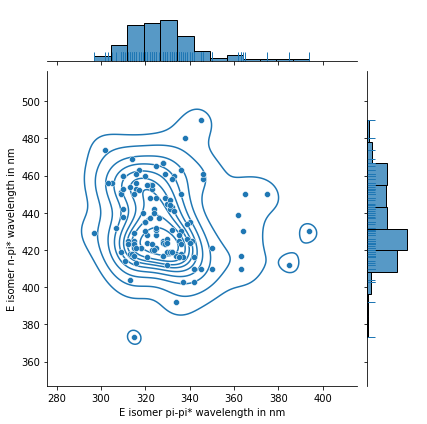

In [263]:
g = sns.jointplot('E isomer pi-pi* wavelength in nm', 'E isomer n-pi* wavelength in nm', data=data_subset)
g.plot_joint(sns.kdeplot, zorder=0, levels=10)
g.plot_marginals(sns.rugplot, height=.15, clip_on=False)

<AxesSubplot:>

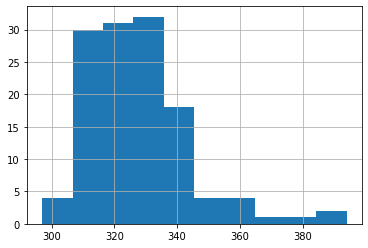

In [264]:
data_subset['E isomer pi-pi* wavelength in nm'].hist()

<AxesSubplot:>

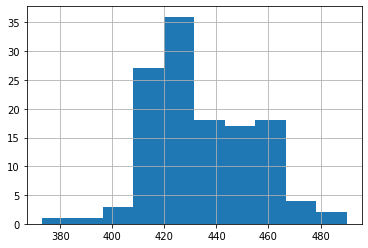

In [265]:
data_subset['E isomer n-pi* wavelength in nm'].hist()

In [300]:
test_mask_hard = (data['E isomer pi-pi* wavelength in nm']   > 33) & (data['E isomer n-pi* wavelength in nm'] < 418) # tuned a bit to again get 100 train examples
train_data_hard = data[~test_mask_hard]
test_data_hard = data[test_mask_hard]

In [301]:
len(test_data_hard)

23

In [302]:
len(train_data_hard)

104

In [303]:
train_prompts_smiles_hard = generate_inverse_photoswitch_prompts(train_data_hard, 'SMILES')
test_prompts_smiles_hard = generate_inverse_photoswitch_prompts(test_data_hard, 'SMILES')

train_prompts_selfies_hard = generate_inverse_photoswitch_prompts(train_df, 'selfies')
test_prompts_selfies_hard = generate_inverse_photoswitch_prompts(test_df, 'selfies')

train_smiles_hard = train_prompts_smiles_hard['completion'].apply(lambda x: x.split('@@@')[0])
test_smiles_hard = test_prompts_smiles_hard['completion'].apply(lambda x: x.split('@@@')[0])
train_prompts_smiles_hard['SMILES'] = train_smiles_hard
test_prompts_smiles_hard['SMILES'] = test_smiles_hard

train_prompts_selfies_hard['SMILES'] = train_smiles_hard
test_prompts_selfies_hard['SMILES'] = test_smiles_hard

In [304]:
model_smiles_hard, train_filename_smiles_hard = train_inverse_model(train_data_hard, 'SMILES')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [313]:
results_smiles_hard = test_inverse_model(model_smiles_hard, test_prompts_smiles_hard, train_prompts_smiles_hard, representation='SMILES')

Testing temperature 0 for SMILES


2022-11-24 15:02:14.419 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=NOC(C)=C1/N=N/C2=CC(C(F)(F)F)=CC=C2
2022-11-24 15:02:14.554 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.25 for SMILES


2022-11-24 15:02:54.991 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(C(C)=NN1)/N=N/C2=CC(C(F)(F)F)=CC=C2
2022-11-24 15:02:55.090 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.5 for SMILES


2022-11-24 15:03:38.457 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(C(C)=NN1)/N=N/C2=CC(C(F)(F)F)=CC=C2
2022-11-24 15:03:38.485 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.75 for SMILES


2022-11-24 15:04:13.896 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(/N=N/C2=CC=CN=C2)C=NC=C1
2022-11-24 15:04:13.930 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.0 for SMILES


2022-11-24 15:04:46.147 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(/N=N/C2=CC=CC=C2)C=NC=C1
2022-11-24 15:04:46.182 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.25 for SMILES


2022-11-24 15:05:15.315 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1C(C(OCC)=O)=CC=C(/N=N/C2=CC=Cat)C=C1
2022-11-24 15:05:15.356 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.5 for SMILES


2022-11-24 15:05:39.488 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: TB(velength=F)(C=F){C1=CC=CC=C1/N=N/C2=CC=CC=C2FOC?
2022-11-24 15:05:39.515 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(
/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/gpt3forchem/output.py:238: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(gen_mol_act.T)
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/kevinmaikjablonk

In [316]:
summarized_metrics_smiles_hard = []

for metric in results_smiles_hard:
    try:
        res = {
            'temperature': metric['meta']['temperature'],
            'fractions_valid_smiles': metric['fractions_valid_smiles'],
            'fractions_smiles_in_train': metric['fractions_smiles_in_train'],
            'unique_smiles': metric['unique_smiles'],
            'frechet_chemnet': metric['frechet_chemnet'][0],
            'pi_pi_star_mae': metric['pi_pi_star_metrics']['mean_absolute_error'],
            'n_pi_star_mae': metric['n_pi_star_metrics']['mean_absolute_error'],
        }
        summarized_metrics_smiles_hard.append(res)
    except Exception as e:
        print(e)
        pass

'float' object is not subscriptable


In [317]:
summarized_metrics_smiles_hard = pd.DataFrame(summarized_metrics_smiles_hard)

In [318]:
summarized_metrics_smiles_hard

,temperature,fractions_valid_smiles,fractions_smiles_in_train,unique_smiles,frechet_chemnet,pi_pi_star_mae,n_pi_star_mae
0,0.00,1.000000,1.000000,0.043478,39.235189,23.205296,10.792123
1,0.25,1.000000,1.000000,0.304348,17.735503,19.892982,16.141966
2,0.50,1.000000,0.869565,0.695652,15.898052,20.169941,14.506838
3,0.75,0.913043,0.666667,0.904762,9.474801,18.673824,22.630928
4,1.00,0.782609,0.222222,1.000000,14.653805,12.255053,31.298962
5,1.25,0.434783,0.500000,1.000000,16.453481,20.631294,22.504026


In [319]:
model_selfies_hard, train_filename_selfies_hard = train_inverse_model(train_data_hard, 'selfies')

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [321]:
results_selfies_hard = test_inverse_model(model_selfies_hard, test_prompts_selfies_hard, train_prompts_selfies_hard, representation='selfies')

Testing temperature 0 for selfies


2022-11-25 09:59:45.535 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(C(C)=NN1)/N=N/C2=CC(F)=CC=C2
2022-11-25 09:59:45.563 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.25 for selfies


2022-11-25 10:00:25.217 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(C(C)=NN1)/N=N/C2=CC(F)=CC=C2
2022-11-25 10:00:25.238 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.5 for selfies


2022-11-25 10:01:03.136 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=NOC(C)=C1/N=N/C2=CC(F)=CC=C2
2022-11-25 10:01:03.157 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 0.75 for selfies


2022-11-25 10:01:41.965 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC=C(/N=N/C1=CC=C(F)C=C1F)C=CC=C
2022-11-25 10:01:41.996 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.0 for selfies


2022-11-25 10:02:32.272 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(/N=N/C=CC(O)=CS)CCS=NC=C1C
2022-11-25 10:02:32.293 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.25 for selfies


2022-11-25 10:03:10.633 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: CC1=C(C(C)=NN1)/N=N/C=CCC=C
2022-11-25 10:03:10.657 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(


Testing temperature 1.5 for selfies


2022-11-25 10:03:41.477 | DEBUG    | gpt3forchem.output:test_inverse_photoswitch:771 - Loaded predictions. Example: [Cl][C][=C][Branch1][Branch1][=N][/N][=N][/C][=C][C][=C][C][Branch1][C][Cl][=C][Ring1][)[C][=C][Cap1][=C][C]
2022-11-25 10:03:41.510 | INFO     | gpt3forchem.output:_load_chemnet:217 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/fcd/FCD.py:194: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  gen_mol_act = model.predict_generator(
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [324]:
summarized_metrics_seflies_hard = []

for metric in results_selfies_hard:
    try:
        res = {
            'temperature': metric['meta']['temperature'],
            'fractions_valid_smiles': metric['fractions_valid_smiles'],
            'fractions_smiles_in_train': metric['fractions_smiles_in_train'],
            'unique_smiles': metric['unique_smiles'],
            'frechet_chemnet': metric['frechet_chemnet'][0],
            'pi_pi_star_mae': metric['pi_pi_star_metrics']['mean_absolute_error'],
            'n_pi_star_mae': metric['n_pi_star_metrics']['mean_absolute_error'],
        }
        summarized_metrics_seflies_hard.append(res)
    except Exception as e:
        print(e)
        pass

summarized_metrics_seflies_hard = pd.DataFrame(summarized_metrics_seflies_hard)

'float' object is not subscriptable


In [325]:
summarized_metrics_seflies_hard

,temperature,fractions_valid_smiles,fractions_smiles_in_train,unique_smiles,frechet_chemnet,pi_pi_star_mae,n_pi_star_mae
0,0.00,1.000000,0.000000,0.037037,29.540679,10.027289,19.634239
1,0.25,1.000000,0.555556,0.333333,23.184642,13.117716,17.950243
2,0.50,1.000000,0.703704,0.592593,13.441982,15.978484,16.525245
3,0.75,0.962963,0.384615,0.807692,15.296248,12.086494,17.558458
4,1.00,1.000000,0.111111,1.000000,21.514822,25.507687,14.630626
5,1.25,0.444444,0.000000,1.000000,31.525970,34.722090,13.892576


In [326]:
print(summarized_metrics_smiles_hard.style.format({c: "{:.2f}" for c in summarized_metrics_smiles_hard.columns}).hide_index().to_latex())

\begin{tabular}{rrrrrrr}
temperature & fractions_valid_smiles & fractions_smiles_in_train & unique_smiles & frechet_chemnet & pi_pi_star_mae & n_pi_star_mae \\
0.00 & 1.00 & 1.00 & 0.04 & 39.24 & 23.21 & 10.79 \\
0.25 & 1.00 & 1.00 & 0.30 & 17.74 & 19.89 & 16.14 \\
0.50 & 1.00 & 0.87 & 0.70 & 15.90 & 20.17 & 14.51 \\
0.75 & 0.91 & 0.67 & 0.90 & 9.47 & 18.67 & 22.63 \\
1.00 & 0.78 & 0.22 & 1.00 & 14.65 & 12.26 & 31.30 \\
1.25 & 0.43 & 0.50 & 1.00 & 16.45 & 20.63 & 22.50 \\
\end{tabular}



/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_96029/2843188943.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  print(summarized_metrics_smiles_hard.style.format({c: "{:.2f}" for c in summarized_metrics_smiles_hard.columns}).hide_index().to_latex())


In [328]:
print(summarized_metrics_seflies_hard.style.format({c: "{:.2f}" for c in summarized_metrics_seflies_hard.columns}).hide_index().to_latex())

\begin{tabular}{rrrrrrr}
temperature & fractions_valid_smiles & fractions_smiles_in_train & unique_smiles & frechet_chemnet & pi_pi_star_mae & n_pi_star_mae \\
0.00 & 1.00 & 0.00 & 0.04 & 29.54 & 10.03 & 19.63 \\
0.25 & 1.00 & 0.56 & 0.33 & 23.18 & 13.12 & 17.95 \\
0.50 & 1.00 & 0.70 & 0.59 & 13.44 & 15.98 & 16.53 \\
0.75 & 0.96 & 0.38 & 0.81 & 15.30 & 12.09 & 17.56 \\
1.00 & 1.00 & 0.11 & 1.00 & 21.51 & 25.51 & 14.63 \\
1.25 & 0.44 & 0.00 & 1.00 & 31.53 & 34.72 & 13.89 \\
\end{tabular}



/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_96029/2378457989.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  print(summarized_metrics_seflies_hard.style.format({c: "{:.2f}" for c in summarized_metrics_seflies_hard.columns}).hide_index().to_latex())


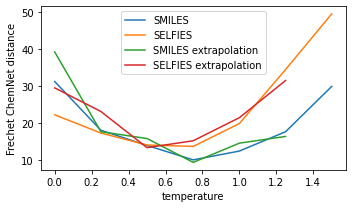

In [342]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(summarized_metrics_smiles['temperature'], summarized_metrics_smiles['frechet_chemnet'], label='SMILES')

ax.plot(summarized_metrics_selfies['temperature'], summarized_metrics_selfies['frechet_chemnet'], label='SELFIES')


ax.plot(summarized_metrics_smiles_hard['temperature'], summarized_metrics_smiles_hard['frechet_chemnet'], label='SMILES extrapolation')

ax.plot(summarized_metrics_seflies_hard['temperature'], summarized_metrics_seflies_hard['frechet_chemnet'], label='SELFIES extrapolation')

ax.legend()

ax.set_xlabel('temperature')
ax.set_ylabel('Frechet ChemNet distance')

fig.tight_layout()
fig.savefig('frechet_chemnet_photoswitch.pdf', bbox_inches='tight')